In [20]:
#importing libraries
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd

In [21]:
#reading CSV file using pandas 
df = pd.read_csv('agr_en_train.csv', names = ['unique_id','comment','agr_lvl'])

In [22]:
#We can see how the first example looks like below
print(df.iloc[0])

unique_id                          facebook_corpus_msr_1723796
comment      Well said sonu..you have courage to stand agai...
agr_lvl                                                    OAG
Name: 0, dtype: object


In [23]:
# We store the reviews and labels in two arrays as follows:
reviews = df['comment'].values
labels_str = df['agr_lvl'].values

In [24]:
#we convert the labels from array of string to array of integers for computation i.e. labels 
label2value_dic={'OAG':2,'CAG':1,'NAG':0}

labels=np.zeros(len(labels_str),dtype=int)
for tt,tkey in enumerate(label2value_dic.keys()):
    ind_this=labels_str==tkey
    labels[ind_this]=label2value_dic[tkey]
    print(tt,tkey,np.sum(ind_this))
    
print(np.unique(labels))
print(labels_str,len(labels_str))

0 OAG 2708
1 CAG 4240
2 NAG 5051
[0 1 2]
['OAG' 'NAG' 'OAG' ... 'OAG' 'OAG' 'NAG'] 11999


In [25]:
#splitting the data for train and test in 80/20 ratio
from sklearn.model_selection import train_test_split

reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.20)

In [26]:
#As we have three different labels, we are creating a list of array for more than binary classification.
#Assigning each class a corresponding array of integer as per val2prob dictionary 
def class2prob(ytrain):
    val2prob={0:np.array([1,0,0]),1:np.array([0,1,0]),2:np.array([0,0,1])}
    
    
    for yy,yt in enumerate(ytrain):
        if(yy==0):
            ytrain_prob=val2prob[yt]
        else:
            ytrain_prob=np.row_stack([ytrain_prob,val2prob[yt]])
            
    return ytrain_prob

ytrain_prob=class2prob(y_train)
ytest_prob=class2prob(y_test)

print(y_train)

print('new array',ytrain_prob)

[1 1 0 ... 0 1 1]
new array [[0 1 0]
 [0 1 0]
 [1 0 0]
 ...
 [1 0 0]
 [0 1 0]
 [0 1 0]]


In [27]:
#importing keras pacakges
import keras
from keras.preprocessing.text import Tokenizer

In [28]:
#define the tokenizer: https://keras.io/preprocessing/text/ 
#removing all punctuations and special characters
#maximum number of words we are keeping is 2000
tokenizer = Tokenizer(num_words=2000)

#Use tokenisation only on the training data!
#creating a word index by assigning every word a unique integer value
tokenizer.fit_on_texts(reviews_train)

#transforming each comment to an array of integer using word index
X_train = tokenizer.texts_to_sequences(reviews_train)
X_test = tokenizer.texts_to_sequences(reviews_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1  

print(reviews_train[0])
print(X_train[0])
vocab_size

Go and protest at Delhi for ur formers..
[111, 3, 1088, 50, 244, 8, 104]


20650

C:\Users\yasmin\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


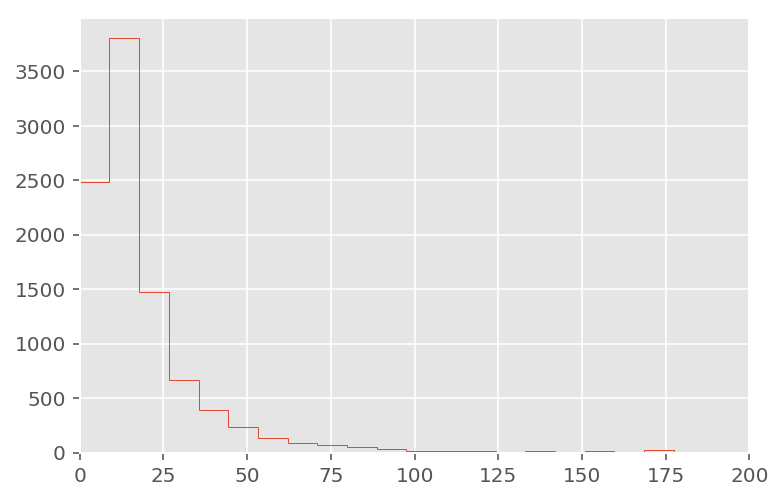

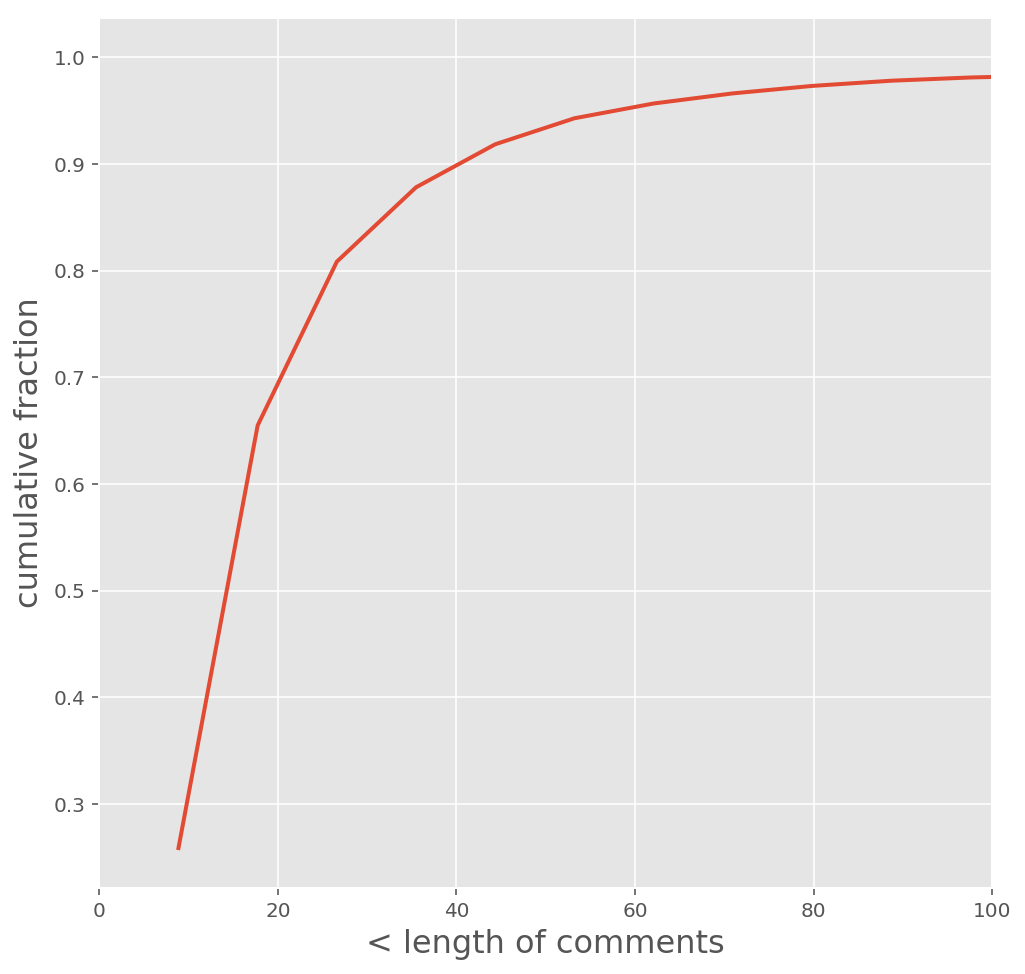

In [29]:
#plotting the variation of length of comments 
import pylab as pl
xlen=[]
for xt in X_train:
    xlen.append(len(xt))

hh=pl.hist(xlen,bins=100,histtype='step')
#pl.yscale('log')
pl.xlim([0,200])

#plotting the cummulative sum of the length of comments to calculate the maximum length for padding
cumhist=np.cumsum(hh[0])
pl.figure(figsize=(8,8))
pl.plot(hh[1][1:],1.0*cumhist/cumhist[-1],lw=2)
pl.xlim([0,100])
pl.xlabel('< length of comments',fontsize=16)
pl.ylabel('cumulative fraction',fontsize=16)
pl.grid('on')
#print(hh)

In [30]:
from keras.preprocessing.sequence import pad_sequences

#max padding length taken is 50
maxlen = 50

#creating padding for the tarin and test data 
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0],len(X_train[0]))

[ 111    3 1088   50  244    8  104    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] 50


In [31]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

#we have used sequential model, so it will follow sequential layering
#we are adding different layer by just using add() function
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen)) #https://keras.io/layers/embeddings/ 
model.add(layers.Conv1D(128, 5, activation='relu')) #https://keras.io/layers/convolutional/
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
#model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            1032500   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 128)           32128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 1,065,951
Trainable params: 1,065,951
Non-trainable params: 0
_________________________________________________________________


In [33]:
#we are training the model iterating the data on the batches of size 10
training = model.fit(X_train, ytrain_prob, epochs=10, verbose=False, validation_data=(X_test, ytest_prob), batch_size=10)


In [38]:
#evaluating the models accuracy during training and testing 
loss, accuracy = model.evaluate(X_train, ytrain_prob, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training loss: {:.4f}".format(loss))
loss, accuracy = model.evaluate(X_test, ytest_prob, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing loss: {:.4f}".format(loss))

Training Accuracy: 0.9805
Training loss: 0.0508
Testing Accuracy:  0.4996
Testing loss: 2.3460


In [35]:
#calcating precision, recall, and F1 scores using metrics
from sklearn import metrics
prediction=model.predict_classes(X_test)
print(np.unique(prediction),np.unique(y_test),np.unique(y_train))

report = metrics.precision_recall_fscore_support(y_test, prediction)

precision=report[0]
recall=report[1]
f1=report[2]


print('p',precision)
print('recall',recall)
print('f1',f1)


[0 1 2] [0 1 2] [0 1 2]
p [0.63697858 0.40243902 0.45861298]
recall [0.55014606 0.53424658 0.35964912]
f1 [0.59038662 0.45906902 0.40314651]


C:\Users\yasmin\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


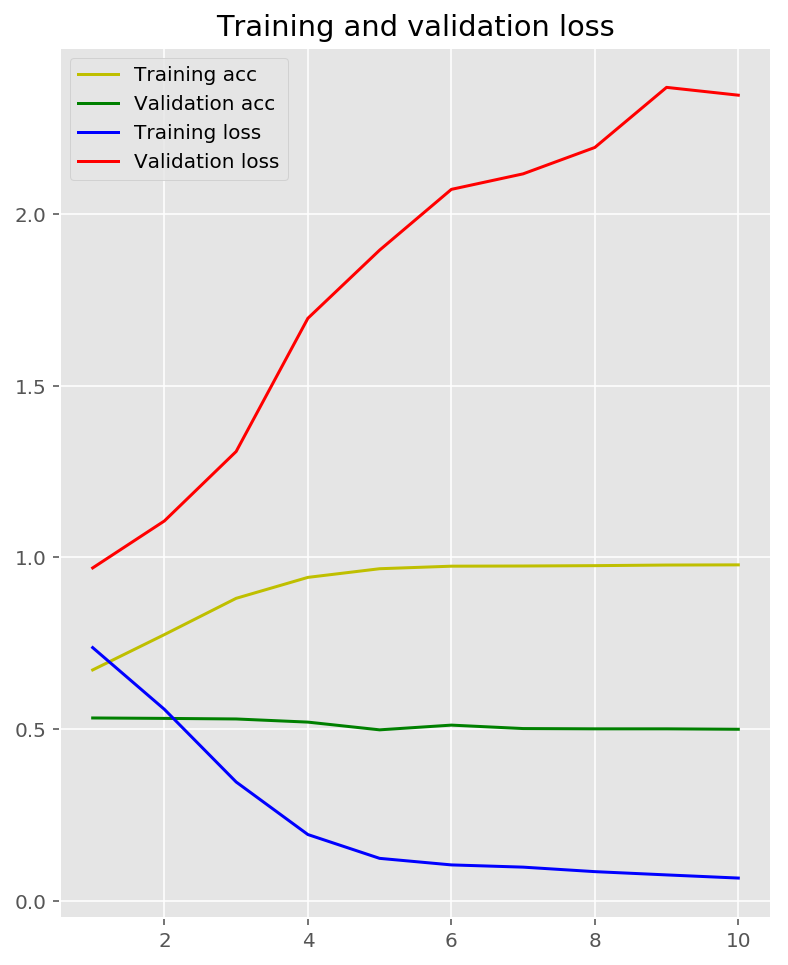

In [42]:
#plotting the train accuracy test accuracy against the accuracy loss results 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(training):
    acc = training.history['acc']
    val_acc = training.history['val_acc']
    loss = training.history['loss']
    val_loss = training.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 2)
    plt.plot(x, acc, 'y', label='Training acc')
    plt.plot(x, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(training)    